In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
device = 'cuda:0'

from torchvision import transforms
from torch.utils.data import DataLoader
from torch_custom_dataloader import GorillaDataset, build_label_index
import torch

batch_size = 150

label_mapping = build_label_index()

dataset_train = GorillaDataset(percent_start=0, percent_end=70, label_mapping=label_mapping)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_val = GorillaDataset(percent_start=70, percent_end=85, label_mapping=label_mapping)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

dataset_test = GorillaDataset(percent_start=85, percent_end=100, label_mapping=label_mapping)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)


Using label cache...
GORILLA_DATA: Using data from index 0 to 22402, covering 22402, total 32005 samples.


Loading Dataset...:   0%|          | 0/22402 [00:00<?, ?it/s]

GORILLA_DATA: Using data from index 22403 to 27203, covering 4800, total 32005 samples.


Loading Dataset...:   0%|          | 0/4800 [00:00<?, ?it/s]

GORILLA_DATA: Using data from index 27204 to 32004, covering 4800, total 32005 samples.


Loading Dataset...:   0%|          | 0/4800 [00:00<?, ?it/s]

In [3]:
import timm

model = timm.create_model('resnet18.a1_in1k', in_chans=3, num_classes=len(label_mapping), pretrained=False)

In [4]:
from typing import List, Tuple
import torch
import wandb
from torch import nn, optim

def get_label(tensor) -> str : 
  label = torch.argmax(tensor, dim=0).item()
  return label

def calculate_accuracy(prediction_and_real: List[Tuple[str, str]]):
  correct = 0

  for [a, b] in prediction_and_real:
    if a == b:
      correct += 1

  return correct / len(prediction_and_real)

epochs = 100
learning_rate = 0.001

with wandb.init(project="GORILLA_FACE", name="training", config={"epochs": epochs}) as run:
  calculate_loss = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  model = model.to(device)

  run.watch(model, log_freq=100)

  prev_val_loss = 10.0

  for epoch in range(epochs):
    model.train()
    print(f'Starting epoch {epoch}')

    run.log({
      "epoch": epoch,
    })

    train_avg_loss = 0.0
    train_avg_acc = 0.0

    for [idx, batch] in enumerate(dataloader_train):
      data, cpu_labels = batch

      data = data.to(device)
      labels = cpu_labels.to(device)
      
      optimizer.zero_grad()
      
      output = model(data)


      accuracy_input = [(get_label(labels[idx]), get_label(pred)) for [idx, pred] in enumerate(output) ]

      accuracy_now = calculate_accuracy(accuracy_input)
      train_avg_acc += accuracy_now
      
      #print(f"out={output}, labels={labels}")
      loss = calculate_loss(output, labels)
      train_avg_loss += loss.item()

      if idx % 50 == 0:
        run.log({
          "batch_loss": loss.item(),
          "batch": epoch * len(dataloader_train) + idx
        })

      loss.backward()
      
      optimizer.step()

    train_avg_loss = train_avg_loss / len(dataloader_train)
    train_avg_acc = train_avg_acc / len(dataloader_train)
    
    # Validation

    val_avg_loss = 0.0
    val_avg_acc = 0.0
    model.eval()
    
    with torch.no_grad():
      for [idx, batch] in enumerate(dataloader_val):
        data, labels = batch
        data = data.to(device)

        labels = labels.to(device)
        output = model(data)

        accuracy_input = [(get_label(labels[idx]), get_label(pred)) for [idx, pred] in enumerate(output) ]

        accuracy_now = calculate_accuracy(accuracy_input)
        val_avg_acc += accuracy_now

        loss = calculate_loss(output, labels)
        val_avg_loss += loss.item()


    val_avg_loss = val_avg_loss / len(dataloader_val)
    val_avg_acc = val_avg_acc / len(dataloader_val)

    run.log({
      "train/loss": train_avg_loss,
      "train/accuracy": train_avg_acc,
      "val/loss": val_avg_loss,
      "val/accuracy": val_avg_acc,
      "epoch": epoch,
    })

    # TODO: would implement something good here :D
    # if val_avg_loss < prev_val_loss:
    #   prev_val_loss = val_avg_loss
    # else:
    #   print(f"Killed early, no smaller loss. {val_avg_loss} vs. {prev_val_loss}")
    #   break


wandb: Currently logged in as: mikmuellerdev (mikmuellerdev-university-of-potsdam) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Starting epoch 0
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
Starting epoch 11
Starting epoch 12
Starting epoch 13
Starting epoch 14
Starting epoch 15
Starting epoch 16
Starting epoch 17
Starting epoch 18
Starting epoch 19
Starting epoch 20
Starting epoch 21
Starting epoch 22
Starting epoch 23
Starting epoch 24
Starting epoch 25
Starting epoch 26
Starting epoch 27
Starting epoch 28
Starting epoch 29
Starting epoch 30
Starting epoch 31
Starting epoch 32
Starting epoch 33
Starting epoch 34
Starting epoch 35
Starting epoch 36
Starting epoch 37
Starting epoch 38
Starting epoch 39
Starting epoch 40
Starting epoch 41
Starting epoch 42
Starting epoch 43
Starting epoch 44
Starting epoch 45
Starting epoch 46
Starting epoch 47
Starting epoch 48
Starting epoch 49
Starting epoch 50
Starting epoch 51
Starting epoch 52
Starting epoch 53
Starting epoch 54
Starting epoch 55
St

batch,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
batch_loss,▂▁▁▁▁▁█▁▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▄▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
train/accuracy,▁████████▆██████████████████▇████████▇██
train/loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/accuracy,▄▇█▄██████▅███████████▁█████████████████
val/loss,▄▁▁▁▁▃▁▁▂▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch,14950
batch_loss,0.00029
epoch,99
train/accuracy,0.99991


In [8]:
torch.save(model.state_dict(), 'face_model.pth')

predicted: 60 | actual = 60


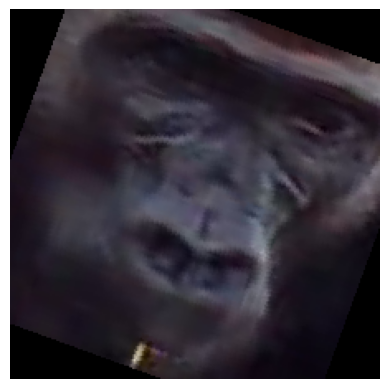

In [35]:
import random
import matplotlib.pyplot as plt

loaded_model = timm.create_model('resnet18.a1_in1k', in_chans=3, num_classes=len(label_mapping), pretrained=False)

weights = torch.load('face_model.pth', map_location=device)
loaded_model.load_state_dict(weights)
loaded_model = loaded_model.to(device)

# Get a test image and label from validation_dataset
img, lbl = dataset_val[random.randint(0, len(dataset_val)-1)]
img_unsqueeze = img.unsqueeze(0).to(device)  # Add batch dimension and move to device

# Load model weights into the model
loaded_model.eval()

# Forward pass
with torch.no_grad():
    pred = loaded_model(img_unsqueeze)
    label = pred_class = torch.argmax(pred, dim=1).item()

actual = get_label(lbl)
print(f"predicted: {label} | actual = {actual}")

# Convert tensor to numpy and transpose to (H, W, C)
img_np = img.cpu().numpy().transpose(1, 2, 0)
plt.imshow(img_np.squeeze(), cmap='gray')
plt.axis('off')
plt.show()


In [2]:
from torch_custom_dataloader import generate_synthetic_data

generate_synthetic_data()

Generating...:   0%|          | 0/865 [00:00<?, ?it/s]